In [4]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy
import matplotlib.path as mpath
from functions import compute_ivt,to_nc
from matplotlib import rc,animation
from matplotlib.animation import FuncAnimation
from IPython import display
import pandas as pd

4887.866666666667
*_AR_detection_p93_ssp245.nc
*_AR_detection_p93_ssp585.nc


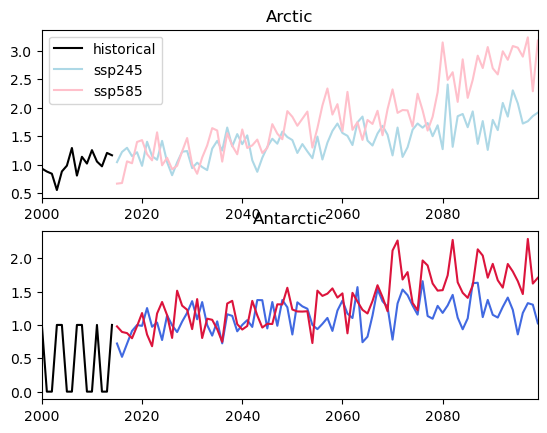

In [8]:
ax = plt.subplot(211)
ax1 = plt.subplot(212)

AR_hist = xr.open_mfdataset("*_AR_detection_p93_historical.nc")
AR_hist_yr_ARC = AR_hist.sel(lat=slice(60,90))
AR_hist_yr_ARC = AR_hist_yr_ARC.groupby(AR_hist_yr_ARC.time.dt.year).sum()
AR_hist_yr_ARC = AR_hist_yr_ARC.reduce(np.sum,dim=('lat','lon'))
AR_hist_yr_ANT = AR_hist.sel(lat=slice(-90,-60))
AR_hist_yr_ANT = AR_hist_yr_ANT.groupby(AR_hist_yr_ANT.time.dt.year).sum()
AR_hist_yr_ANT = AR_hist_yr_ANT.reduce(np.sum,dim=('lat','lon'))

baseline_arc = np.mean(AR_hist_yr_ARC.ivt.values)
baseline_ant = np.mean(AR_hist_yr_ANT.ivt.values)
print(baseline_arc)

histar = (AR_hist_yr_ARC.ivt.values/baseline_arc)
histant = (AR_hist_yr_ANT.ivt.values/baseline_ant)

ax.plot(AR_hist_yr_ARC.year,histar,label='historical',color='k')
ax1.plot(AR_hist_yr_ANT.year,histant.astype(int),color='k')
#ax.plot(histar,label='historical',color='k')
#ax1.plot(histant.astype(int),color='k')



cols = ['royalblue','crimson']
cols1 = ['lightblue','pink']


k=0
for ssp in ["ssp245","ssp585"]:
    print("*_AR_detection_p93_"+ssp+".nc")
    AR_fut = xr.open_mfdataset("*_AR_detection_p93_"+ssp+".nc")
    AR_fut_yr_ARC = AR_fut.sel(lat=slice(60,90))
    AR_fut_yr_ARC = AR_fut_yr_ARC.groupby(AR_fut_yr_ARC.time.dt.year).sum()
    AR_fut_yr_ARC = AR_fut_yr_ARC.reduce(np.sum,dim=('lat','lon'))
    AR_fut_yr_ANT = AR_fut.sel(lat=slice(-90,-60))
    AR_fut_yr_ANT = AR_fut_yr_ANT.groupby(AR_fut_yr_ANT.time.dt.year).sum()
    AR_fut_yr_ANT = AR_fut_yr_ANT.reduce(np.sum,dim=('lat','lon'))
    
    arloc = (AR_fut_yr_ARC.ivt.values/baseline_arc)
    antloc = (AR_fut_yr_ANT.ivt.values/baseline_ant)
    ax1.plot(AR_fut_yr_ANT.year,antloc,color=cols[k])
    ax.plot(AR_fut_yr_ARC.year,arloc,label=ssp,color=cols1[k])

    if ssp=='ssp245':
        arloc245 = arloc
    else:
        arloc585 = arloc
    
    k=k+1
    AR_fut.close()
    
ax.legend()
ax.set_title('Arctic')
ax1.set_title('Antarctic')
ax.set_xlim(2000,2099)
ax1.set_xlim(2000,2099)
plt.show()